# Data

Import of data and calculation of the difference between post-surgical and baseline levels.


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from scipy.stats import skew
import numpy as np

data = pd.read_excel("Silicone_Implants.xlsx")
data['difference'] = data['post_surgical_level'] - data['baseline_level']

data.head()

,patient_ID,baseline_level,post_surgical_level,difference
0,1,0.15,0.21,0.06
1,2,0.13,0.24,0.11
2,3,0.39,0.10,-0.29
3,4,0.20,0.12,-0.08
4,5,0.39,0.28,-0.11


# Visualization
I decided to visualize the data using a boxplot, a histogram of the differences, and a paired line plot.

**Boxplot**
- Shows central tendency, spread, and outliers
- Ideal for comparing both distributions
- First interpretations: Post-surgical median is slightly higher → possible increase

**Histogram of Differences**
- Focuses on individual change per patient
- Helps assess symmetry (important for potential t-test)
- First interpretations: Mostly symmetric, slightly left-skewed

**Paired Line Plot**
- Shows before-after trend for each woman
- Reveals whether there's a consistent increase
- First interpretations: Many lines go up but some go down, indicating variability in response


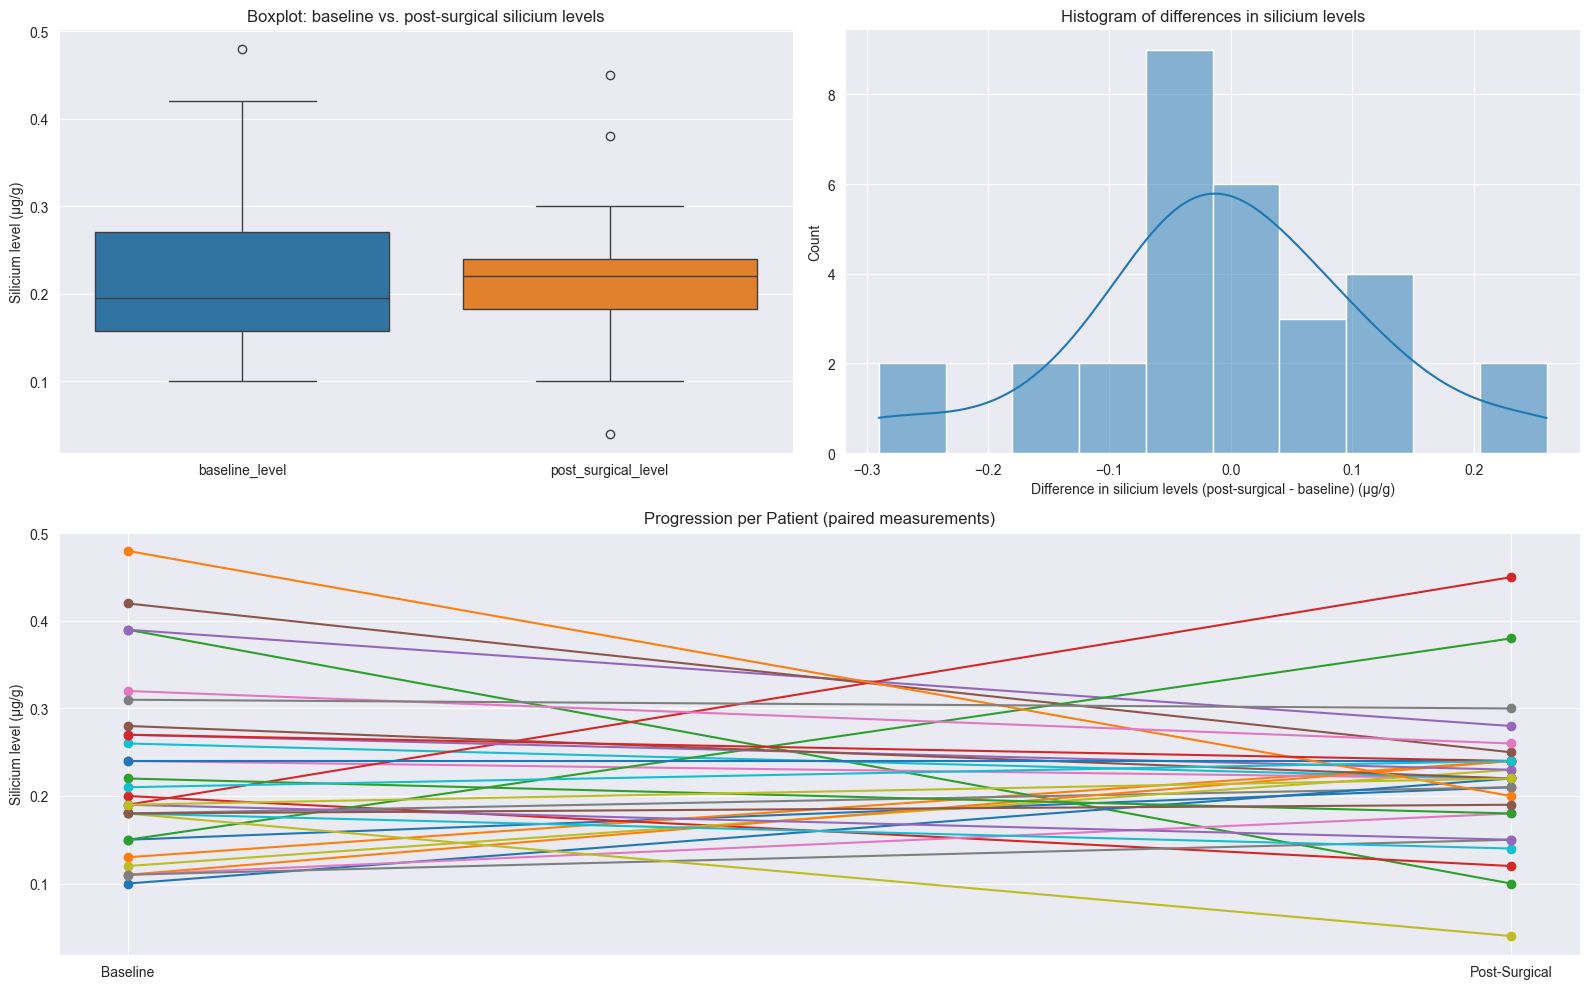

In [18]:
plt.figure(figsize=(16, 10))

# boxplot
plt.subplot(2, 2, 1)
sns.boxplot(data=data[['baseline_level', 'post_surgical_level']])
plt.title("Boxplot: baseline vs. post-surgical silicium levels")
plt.ylabel("Silicium level (µg/g)")

# histogram
plt.subplot(2, 2, 2)
sns.histplot(data['difference'], bins=10, kde=True)
plt.title("Histogram of differences in silicium levels")
plt.xlabel("Difference in silicium levels (post-surgical - baseline) (µg/g)")

# pair plot
plt.subplot(2, 1, 2)
for i in range(len(data)):
    plt.plot([1, 2], [data['baseline_level'][i], data['post_surgical_level'][i]], marker='o')
plt.xticks([1, 2], ['Baseline', 'Post-Surgical'])
plt.title("Progression per Patient (paired measurements)")
plt.ylabel("Silicium level (µg/g)")

plt.tight_layout()
plt.show()

# Z-test

Since the set contains >= 30 measurements, we can use a z-test (according to the decision tree).
However, since the data is just exactly 30 measurements and we dont't know the population standard deviation, i will do a paired t-test too.

## Step 1 – Assumptions
We use the paired differences:

$D_i = X_{i,\text{post}} - X_{i,\text{baseline}}$

* paired measurements (before / after surgery)
* **i.i.d.** independent and identically distributed random variables
* metric variable (Plasma-Silicium, µg/g)
* **CLT** $n = 30$ -> according to the Central Limit Theorem, this is sufficient for approximate normality
    * The shapiro test below results in a p-value of 0.347 -> no evidence against normality
* Population standard deviation σ is unknown -> we estimate it with the sample standard deviation $s_D$

*These assumptions relate to the `z-test_Solution.ipynb` from week 5. Since i don't know the population standard deviation but the decision tree says to use a z-test, i do both. I a practical setting, i would use a paired t-test instead of a z-test since - from my knowledge - the population standard deviation is required for a z-test.*

In [19]:
shapiro_p = stats.shapiro(data["difference"])[1]
print(f"Shapiro-p = {shapiro_p:.3f}")


Shapiro-p = 0.347


## Step 2 – Formulate the hypotheses

We want to know whether the mean difference is **larger than 0**.

* Null-hypothesis $H_0:μ_D = 0$
* Alternative $H_1: μ_D > 0$   (one-sided)


## Step 3 – Test statistic

In [20]:
diff = data["difference"].to_numpy()
n = diff.size
mean_of_d = diff.mean()
standard_dev_diff = diff.std(ddof=1)
standard_error_mean_diff = standard_dev_diff / np.sqrt(n)

z_stat = mean_of_d / standard_error_mean_diff

print(f"z = {z_stat:.3f}")

z = -0.329


## Step 4 – p-value

In [21]:
p_value = stats.norm.sf(z_stat)
print(f"p-value = {p_value:.3f}")

p-value = 0.629


## Step 5 - Significance level
$\alpha = 0.05$

## Step 6 - Confidence interval


In [22]:
z_crit = stats.norm.ppf(0.95)
lower = mean_of_d - z_crit * standard_error_mean_diff
print(f"One-sided 95% interval: ({lower:.3f}, ∞)")

One-sided 95% interval: (-0.044, ∞)


## Step 7 – Decision and interpretation

Since the p-value is larger than the significance level, we **fail to reject** the null hypothesis.
This means that we do not have sufficient evidence to conclude that the mean difference in silicium levels after surgery is greater than zero.




# Paired t-test
As mentioned above, since the population standard deviation is unknown, i will also perform a paired t-test. (which i prefer for this case)


## Step 1 – Assumptions

Again, we use the paired differences:
$D_i = X_{i,\text{post}} - X_{i,\text{baseline}}$

* paired measurements (before / after surgery)
* **i.i.d.** independent and identically distributed random variables
* metric variable (Plasma-Silicium, µg/g)
* Normality: In contrast to the z-test i will not rely on the CLT, but rather on Q-Q plots and the Shapiro-Wilk test to check for normality.
* No extreme outliers which i will check with a boxplot

Normality and no extreme outliers are not proved yet.


### Normality: Q-Q Plot

The below Q-Q plot shows a good fit to the normal distribution.

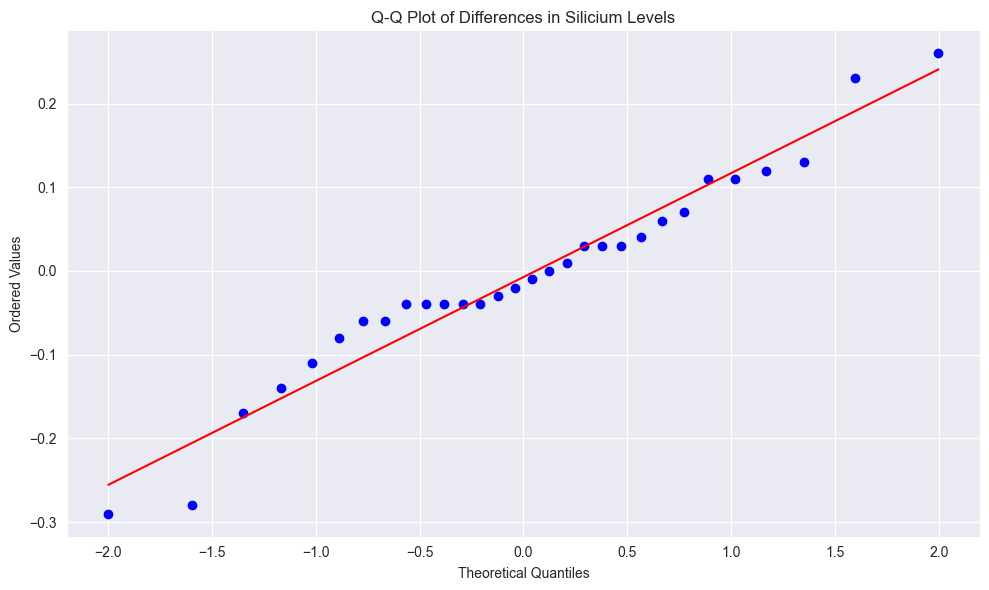

In [23]:
plt.figure(figsize=(10, 6))

stats.probplot(data["difference"], dist="norm", plot=plt)
plt.title("Q-Q Plot of Differences in Silicium Levels")
plt.xlabel("Theoretical Quantiles")

plt.tight_layout()
plt.show()


### Normality: Shapiro-Wilk Test

Results of the Shapiro-Wilk test indicate that the data is normally distributed (p-value > 0.05).

In [24]:
test_stat, p_value = stats.shapiro(data["difference"])
print(f"Shapiro-Wilk Test Statistic: {test_stat:.3f}, p-value: {p_value:.3f}")

Shapiro-Wilk Test Statistic: 0.962, p-value: 0.347


### Outliers: IQR and z-score

Based on the z-scores and IQR, no extreme outliers are detected in the differences.

In [25]:
Q1 = data["difference"].quantile(0.25)
Q3 = data["difference"].quantile(0.75)
IQR = Q3 - Q1
print(f"IQR: {IQR:.3f}, Q1: {Q1:.3f}, Q3: {Q3:.3f}")

z_scores = (data["difference"] - data["difference"].mean()) / data["difference"].std()
outliers = data["difference"][np.abs(z_scores) > 3]
print(f"Outliers (z-score > 3): {outliers.values}")

IQR: 0.110, Q1: -0.055, Q3: 0.055
Outliers (z-score > 3): []


### Outliers: Boxplot

The boxplot shows some outliers, but they are not extreme enough to violate the assumptions of the t-test.

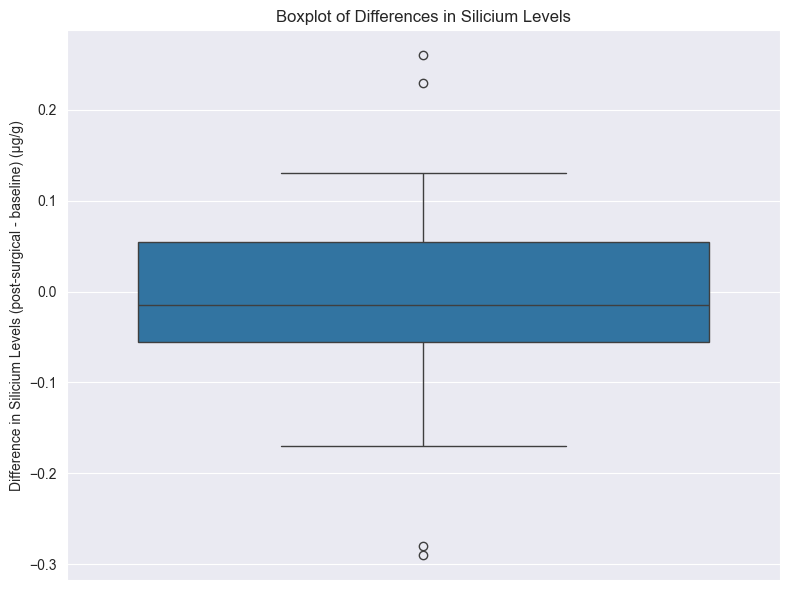

In [26]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data["difference"])
plt.title("Boxplot of Differences in Silicium Levels")
plt.ylabel("Difference in Silicium Levels (post-surgical - baseline) (µg/g)")
plt.tight_layout()
plt.show()

### Conclusion of Assumptions
Based on the Q-Q plot, Shapiro-Wilk test, and boxplot, i conclude that the assumptions for the paired t-test are met which is why the prerequisite for exercise 1.ii.a are met too.

## Step 2 – Formulate the hypotheses

Same hypotheses as for the z-test.


* Null-hypothesis $H_0:μ_D = 0$
* Alternative $H_1: μ_D > 0$   (one-sided)

## Step 3 - Test statistic

In [27]:
test_statistic, p_value = stats.ttest_1samp(data["difference"], 0, alternative='greater')
print(f"t-statistic = {test_statistic:.3f}")

t-statistic = -0.329


## Step 4 - p-value

In [28]:
print(f"p-value = {p_value:.3f}")

p-value = 0.628


## Step 5 - Significance level
$\alpha = 0.05$

## Step 6 - Confidence interval

Interestingly, the confidence interval and p-value are almost identical to the ones from the z-test, which is expected since the sample size is large enough.

In [29]:
t_crit = stats.t.ppf(0.95, n-1)
mean_of_d = data["difference"].mean()
standard_dev_diff   = data["difference"].std(ddof=1)
standard_error_mean_diff   = standard_dev_diff / np.sqrt(n)
lower = mean_of_d - t_crit * standard_error_mean_diff
print(f"One-sided 95% interval: ({lower:.3f}, ∞)")

One-sided 95% interval: (-0.045, ∞)


## Step 7 – Decision and interpretation

As with the z-test, we fail to reject the null hypothesis since the p-value is larger than the significance level.

# Conclusion of the Parametric Tests (Exercise 1.ii)

In my opinion the prerequisites for the parametric tests are met and the z-test as well as the paired t-test show that we do not have sufficient evidence to conclude that the mean difference in silicium levels after surgery is greater than zero.

# Non-parametric Tests

For exercise 1.iii i will perform a non-parametric test and then compare the outcomes with the parametric tests.
Therefore i assume that the data is not normally distributed and that the assumptions for the parametric tests are not met.
I also assume symmetry of the distribution based on the histogram of the differences, which is why i will use the Wilcoxon signed-rank test.

## Step 1 – Assumptions

* paired measurements (before / after surgery)
* **i.i.d.** independent and identically distributed random variables
* metric variable (Plasma-Silicium, µg/g)
* Symmetry: Based on the histogram of the differences, i assume that the distribution is symmetric.
    * I will check this assumption below.

### Symmetry: Histogram and Boxplot

Since the skewness is < |0.5|, i assume that the distribution is symmetric.
This also aligns with the histogram which shows a slightly left skewed distribution.

In [30]:
sk = skew(data["difference"], bias=False)
print(f"skewness = {sk:.3f}")

Schiefe = -0.203


## Step 2 – Formulate the hypotheses

We want to know whether the median difference is **larger than 0**.

* Null-hypothesis $H_0:m_D = 0$
* Alternative $H_1: m_D > 0$   (one-sided)

## Step 3 - Test statistic

In [36]:
test_statistic, p_value = stats.wilcoxon(data["difference"], alternative='greater')
print(f"Wilcoxon test statistic = {test_statistic:.3f}")

Wilcoxon test statistic = 198.500, p-value = 0.659


## Step 4 - p-value

In [37]:
print(f"p-value = {p_value:.3f}")

p-value = 0.659


## Step 5 - Significance level
$\alpha = 0.05$

## Step 6 - Confidence interval

Pretty much the same result as in the parametric tests.

In [38]:
# The Wilcoxon signed-rank test does not provide a confidence interval directly, but we can estimate it using the median and the interquartile range (IQR).
median_diff = data["difference"].median()
q1 = data["difference"].quantile(0.25)
q3 = data["difference"].quantile(0.75)
iqr = q3 - q1
lower_bound = median_diff - 1.645 * (iqr / np.sqrt(n))

print(f"One-sided 95% interval: ({lower_bound:.3f}, ∞)")


One-sided 95% interval: (-0.048, ∞)


## Step 7 – Decision and interpretation

Since the p-value is larger than the significance level, we **fail to reject** the null hypothesis.

In all three tests (z-test, paired t-test, and Wilcoxon signed-rank test) we do not have sufficient evidence to conclude that the mean or median difference in silicium levels after surgery is greater than zero.
